# This notebook runs a covariance based Monte Carlo propagation in ADAM

In [1]:
from adam import PropagationParams
from adam import OpmParams
from adam import ConfigManager
from adam import ProjectsClient
from adam import AdamProcessingService
from adam import MonteCarloResults
import matplotlib.pyplot as plt


This sets up authenticated access to the server. It needs to be done before pretty much everything you want to do with ADAM.

In [2]:
# ConfigManager loads the config set up via adamctl.
# See the README at https://github.com/B612-Asteroid-Institute/adam_home/blob/master/README.md
config = ConfigManager().get_config('adam_dev')
project = ProjectsClient().get_project_from_config(config)
aps = AdamProcessingService()

## Example Inputs

The PropagationParameters sent to the propagation API will operate on either Keplerian or Cartesian elements.

In [3]:
# 6x1 state vector (position [km], velocity [km/s])
state_vec = [130347560.13690618,
             -74407287.6018632,
             -35247598.541470632,
             23.935241263310683,
             27.146279819258538,
             10.346605942591514]

# Lower triangular covariance matrix (21 elements in a list)
covariance = [3.331349476038534e-04, + \
              4.618927349220216e-04, 6.782421679971363e-04, + \
             -3.070007847730449e-04, -4.221234189514228e-04, 3.231931992380369e-04, + \
             -3.349365033922630e-07, -4.686084221046758e-07, 2.484949578400095e-07, 4.296022805587290e-10, + \
             -2.211832501084875e-07, -2.864186892102733e-07, 1.798098699846038e-07, 2.608899201686016e-10, 1.767514756338532e-10, + \
             -3.041346050686871e-07, -4.989496988610662e-07, 3.540310904497689e-07, 1.869263192954590e-10, 1.008862586240695e-10, 6.224444338635500e-10]

### Set Parameters

Commented parameters are optional. Uncomment to use.

In [4]:
propagation_params = PropagationParams({
    'start_time': '2017-10-04T00:00:00Z',   # propagation start time in ISO format
    'end_time': '2017-10-11T00:00:00Z',     # propagation end time in ISO format

    'project_uuid': config['workspace'],
    'description': 'Jupyter Covariance Monte Carlo Example',
    'monteCarloDraws': 10,
    'propagationType': 'MONTE_CARLO',
    'stopOnImpact': True,
    'step_size': 86400,
    'stopOnCloseApproach': False,
    'stopOnImpactAltitudeMeters': 500000,
    'closeApproachRadiusFromTargetMeters': 7000000000
})

opm_params = OpmParams({
    'epoch': '2017-10-04T00:00:00Z',
    'state_vector': state_vec,
    'covariance': covariance,   # object covariance
            
#     'mass': 500.5,              # object mass
#     'solar_rad_area': 25.2,     # object solar radiation area (m^2)
#     'solar_rad_coeff': 1.2,     # object solar radiation coefficient
#     'drag_area': 33.3,          # object drag area (m^2)
#     'drag_coeff': 2.5,          # object drag coefficient
    
})

### Submit and Run Propagation

In [5]:
batch_run = aps.execute_batch_propagation(
    project, 
    propagation_params, 
    opm_params, 
    object_id="CartesianCovarianceObject01",
    user_defined_id="CartesianCovarianceWorkbook"
)


### Get Status

In [6]:
# See example notebook on how to search the ADAM system for previous submitted jobs
print(batch_run.check_status())
batch_run.wait_for_complete(max_wait_sec=500, print_waiting = True)
print()
print(batch_run.check_status())

CREATED
CREATED
...........RUNNING
......
COMPLETED


### Get Number of Runs

In [7]:
runs_count = batch_run.get_result_ephemeris_count()
print(f'# Runs: {runs_count}')

# Runs: 11


### Get Summary Statistics

In [11]:
stats = batch_run.get_summary()
print(stats)
print(stats.get_misses())

MonteCarloSummary(misses=11, close_approaches=0, impacts=0, pc=0.0)
11


### Get Ephemeris for specific run

[Timestamp('2017-10-04 00:00:00') 130347560.1215 -82288041.18185247
 -2741520.124188401 23.93525301099 29.021885436847892 -1.3053206468802596]


<AxesSubplot:xlabel='Epoch'>

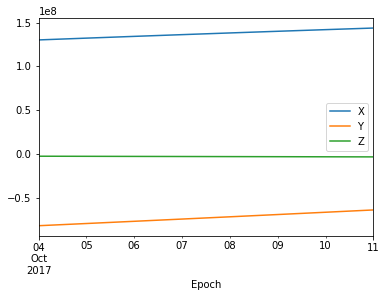

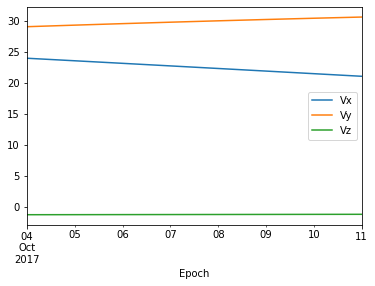

In [12]:
eph = batch_run.get_result_ephemeris(2)
print (eph.values[0])
eph.plot(x='Epoch', y=['X','Y','Z'])
eph.plot(x='Epoch', y=['Vx','Vy','Vz'])


In [13]:
ephem_raw_data = batch_run.get_result_raw_ephemeris(2)
print(ephem_raw_data)

stk.v.11.0
BEGIN Ephemeris
ScenarioEpoch 04 Oct 2017 00:00:00.000000
CentralBody SUN
CoordinateSystem ICRF
InterpolationMethod HERMITE
InterpolationOrder 5
NumberOfEphemerisPoints 8

EphemerisTimePosVel
0.000000000000e+00 1.303475601215e+11 -7.440728762923e+10 -3.524759852527e+10 2.393525301099e+04 2.714628603023e+04 1.034663477009e+04
8.640000000000e+04 1.323979021419e+11 -7.205192333304e+10 -3.434893787648e+10 2.352586639134e+04 2.737449830697e+04 1.045507909983e+04
1.728000000000e+05 1.344127486814e+11 -6.967724037547e+10 -3.344106765429e+10 2.311366185841e+04 2.759347319786e+04 1.055981543093e+04
2.592000000000e+05 1.363918726755e+11 -6.728403766857e+10 -3.252430913687e+10 2.269901843673e+04 2.780319504604e+04 1.066082398765e+04
3.456000000000e+05 1.383350796151e+11 -6.487311473136e+10 -3.159898499688e+10 2.228231051437e+04 2.800366537002e+04 1.075809223578e+04
4.320000000000e+05 1.402422070995e+11 -6.244527022975e+10 -3.066541868402e+10 2.186390678151e+04 2.819490229962e+04 1.0851

### Get ending state vector

In [15]:
end_state_vectors = batch_run.get_final_positions(MonteCarloResults.PositionOrbitType.CLOSE_APPROACH)
print("Close State Vectors")
if len(end_state_vectors) > 0:
    print(f'First close end state: {end_state_vectors[0]}')
else:
    print("None")


end_state_vectors = batch_run.get_final_positions(MonteCarloResults.PositionOrbitType.IMPACT)
print("Impact State Vectors")
if len(end_state_vectors) > 0:
    print(f'First impact end state: {end_state_vectors[0]}')
else:
    print("None")


end_state_vectors = batch_run.get_final_positions(MonteCarloResults.PositionOrbitType.MISS)
print("Miss State Vectors")
if len(end_state_vectors) > 0:
    print(f'First miss end state: {end_state_vectors[0]}')
else:
    print("None")



Close State Vectors
None
Impact State Vectors
None
Miss State Vectors
First miss end state: [numpy.datetime64('2017-10-11T00:00:00.000000'), 1610537925.0534668, -99035106927.5575, -46761937851.233986]
